Imports

In [89]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import requests
import time
import os
import copy
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from PIL import Image
# from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms


Display the matplotlib images inline, and set to interactive mode

In [90]:
%matplotlib inline

plt.ion()

First, load the dataset and print some of the images just to test the loader correctly.

In [91]:
img_32x32_size_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  # ensure that images are 32x32
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # normalize to [-1,1]
])

gtsrb_path = "/content"

train_percent = 0.8 # 80% training set -> 20% validation set

train_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=img_32x32_size_transform)

train_size = int(train_percent*len(train_set))

val_size = int(len(train_set) - train_size)

train_set, val_set = random_split(train_set,[train_size, val_size])

test_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=img_32x32_size_transform)

test_set_size = int(len(test_set)*0.9)

test_vis_size= int(len(test_set) - test_set_size)

test_set, test_vis_set = random_split(test_set,[test_set_size,test_vis_size])

training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

Setting the hyper parameters

In [92]:
bs = 64  # batch size
lr = 0.01  # learning rate
epochs = 20  # number of epochs
momentum = 0.9 # for optimizer
step_size = 7 # step size for
gamma = 0.1 # gamma for learning rate scheduler

Initializing the classes label names

In [93]:
# TODO: create the label names array to map the numbers into label names for presenting predictions

class_names = [
    "Speed limit (20km/h)",         # 0
    "Speed limit (30km/h)",         # 1
    "Speed limit (50km/h)",         # 2
    "Speed limit (60km/h)",         # 3
    "Speed limit (70km/h)",         # 4
    "Speed limit (80km/h)",         # 5
    "End of speed limit (80km/h)",  # 6
    "Speed limit (100km/h)",        # 7
    "Speed limit (120km/h)",        # 8
    "No passing",                   # 9
    "No passing for vehicles over 3.5 metric tons",  # 10
    "Right-of-way at the next intersection",         # 11
    "Priority road",                # 12
    "Yield",                        # 13
    "Stop",                         # 14
    "No vehicles",                  # 15
    "Vehicles over 3.5 metric tons prohibited",      # 16
    "No entry",                     # 17
    "General caution",              # 18
    "Dangerous curve to the left",  # 19
    "Dangerous curve to the right", # 20
    "Double curve",                 # 21
    "Bumpy road",                   # 22
    "Slippery road",                # 23
    "Road narrows on the right",    # 24
    "Road work",                    # 25
    "Traffic signals",              # 26
    "Pedestrians",                  # 27
    "Children crossing",            # 28
    "Bicycles crossing",            # 29
    "Beware of ice/snow",           # 30
    "Wild animals crossing",        # 31
    "End of all speed and passing limits",  # 32
    "Turn right ahead",             # 33
    "Turn left ahead",              # 34
    "Ahead only",                   # 35
    "Go straight or right",         # 36
    "Go straight or left",          # 37
    "Keep right",                   # 38
    "Keep left",                    # 39
    "Roundabout mandatory",         # 40
    "End of no passing",            # 41
    "End of no passing by vehicles over 3.5 metric tons"  # 42
]

Creating the loader for the data

In [94]:
train_data_loader = DataLoader(train_set,batch_size=bs, shuffle=True) # schuffle only in train set
val_data_loader = DataLoader(val_set,batch_size=bs, shuffle=False)
test_data_loader = DataLoader(test_set,batch_size=bs, shuffle=False)
test_vis_data_loader = DataLoader(test_vis_set, batch_size=bs, shuffle=False)

data_loaders = {
    "train": train_data_loader,
    "val" : val_data_loader,
    "test": test_data_loader,
    "vis": test_vis_data_loader
}

data_set_sizes = {
    "train": len(train_data_loader),
    "val": len(val_data_loader),
    "test": len(test_data_loader),
    "vis": len(test_vis_data_loader)
}

Optionally print some images out of the dataset (since batch size is 64, we get 64 images out of the dataset)

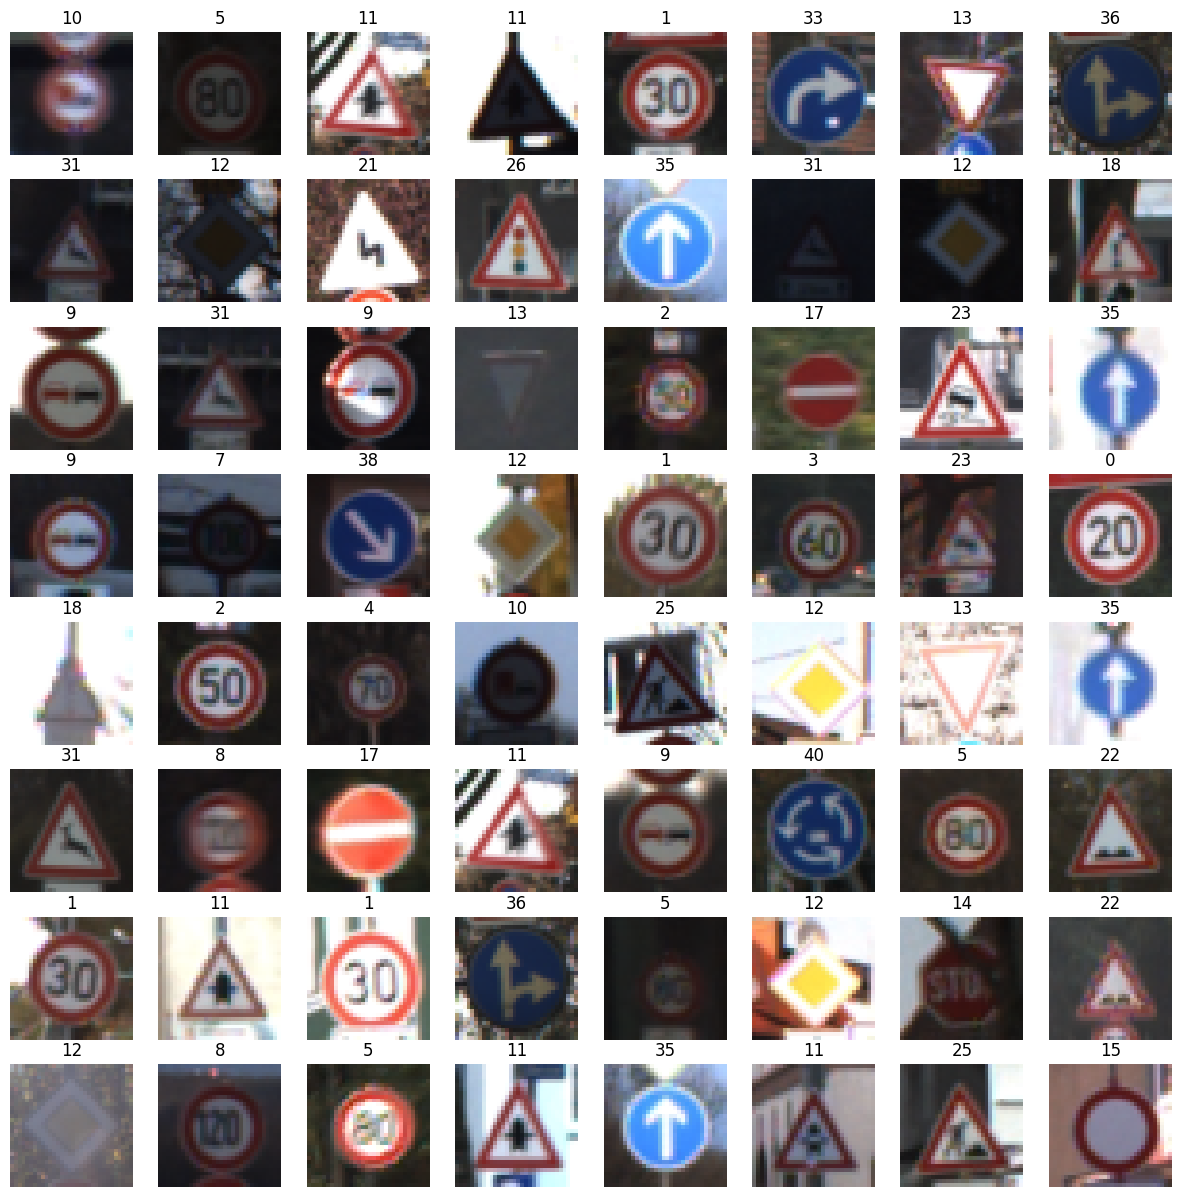

In [95]:
def imshow(images, labels):
  plt.figure(figsize=(15,15))
  for i in range(len(images)):
    plt.subplot(8,8,i+1)
    plt.imshow(images[i].permute(1,2,0)) # (3, 32, 32) -> (32, 32, 3)
    plt.title(labels[i].item())
    plt.axis("off")
  plt.show()

images, labels = next(iter(test_vis_data_loader)) # get a pack (64) of images

imshow(images, labels)

Setting up the model

In [96]:
model = torchvision.models.mobilenet_v2(pretrained=True)

in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
    nn.Linear(in_feature_number, 512),
    nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
    nn.ReLU(),
    nn.Linear(512, 43)
)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using the GPU if available

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Visualizing the loss and accuracy for validation and training

In [98]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    plt.plot(train_acc)
    plt.title("Training accuracy")

    plt.subplot(2,2,2)
    plt.plot(val_acc)
    plt.title("Validation accuracy")

    plt.subplot(2,2,3)
    plt.plot(train_loss)
    plt.title("Training loss")

    plt.subplot(2,2,4)
    plt.plot(val_loss)
    plt.title("Validation loss")

    plt.show()

Setting up the training method

In [99]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    model = model.to(device)

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double() / data_set_sizes[phase]

            if phase == 'train':
                train_acc += [float(epoch_acc)]
                train_loss += [float(epoch_loss)]
            else:
                val_acc += [float(epoch_acc)]
                val_loss += [float(epoch_loss)]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    visualize_metrics(train_acc, val_acc, train_loss, val_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

Setting up the visualizing method

In [100]:
def evaluate_model(model):
    was_training = model.training
    model.eval()

    model = model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    return conf_matrix

Method to show some predictions on unseen images

In [101]:
def show_predictions(model, num_of_images=6):
    was_training = model.training
    model.eval()
    model = model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['vis']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1, 2, 0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Preparing the model for feature extraction (original model's weights are freezed, classfier layer is trainable), setting the loss function, optimizer and learning rate scheduler

In [102]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Train the model

In [103]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

Epoch 1/20
--------------------
train Loss: 136.7822 Acc: 25.2042
val Loss: 98.3495 Acc: 34.8929
Epoch 2/20
--------------------
train Loss: 95.8335 Acc: 35.3483
val Loss: 79.2977 Acc: 39.8929
Epoch 3/20
--------------------
train Loss: 81.4923 Acc: 39.2372
val Loss: 71.0924 Acc: 42.3571
Epoch 4/20
--------------------
train Loss: 73.2371 Acc: 41.8258
val Loss: 65.8314 Acc: 43.5595
Epoch 5/20
--------------------
train Loss: 66.5871 Acc: 43.7237
val Loss: 61.4935 Acc: 45.0119
Epoch 6/20
--------------------
train Loss: 61.4532 Acc: 45.3093
val Loss: 58.5539 Acc: 46.3929
Epoch 7/20
--------------------
train Loss: 52.6028 Acc: 48.3724
val Loss: 53.0130 Acc: 47.8095
Epoch 8/20
--------------------
train Loss: 49.8773 Acc: 49.1982
val Loss: 51.9107 Acc: 47.9286
Epoch 9/20
--------------------
train Loss: 48.3285 Acc: 49.8108
val Loss: 49.7326 Acc: 48.6310
Epoch 10/20
--------------------
train Loss: 47.9468 Acc: 49.9219
val Loss: 49.1584 Acc: 49.0000
Epoch 11/20
--------------------
train

KeyboardInterrupt: 

Evaluate the model form the test data loader

In [ ]:
conf_matrix = evaluate_model(model)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Show some predictions with the model

In [ ]:
show_predictions(model) # 6 images are shown by default

Fine tuning model

In [ ]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Train the model again

In [ ]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

Show some predictions with the fine tuned model again

In [ ]:
conf_matrix = evaluate_model(model)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()